<a href="https://colab.research.google.com/github/fersondahl/Sprint_eng_dados/blob/main/MVP_Engenharia_de_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

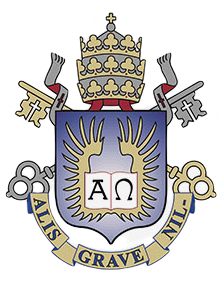



# **PUC - RIO**
---
#### Sprint: Engenharia de Dados
#### Autor: Fernando Söndahl Brito

#0. Introdução e Contexto

> O objetivo desse trabalho é desenvolver o protótipo de uma solução que facilite o processo de roteirização de viagens para turistas. A solução deve ser capaz de receber uma requisição com uma lista de pontos turísticos e quantidades de dias de viagem pretendidas pelo turista, e responder com o melhor possível para que o cliente passe o menor tempo possível se deslocando durante a viagem. Um turismo com tempos de deslocamento minimizados é uma viagem em que o turista passa mais tempo aproveitando as experiências oferidas pelo seu próprio destino;

> Como sendo um protótipo, o trabalho será realizado através de um estudo de caso de um turista que planeja conhecer diversos estádios de futebol em Buenos Aires, capital conhecida por ser o lugar no mundo com mais estádios;

> Por mais que a solução desenvolvida a princípio se apresente como uma ferramenta de prestação de serviço de roteirização, ela conta também com potencial de rentabilização através dos dados gerados pela sua própria utilização;

> Uma solução de computação em nuvem é ideal para esse problema por permitir que o modelo seja disparado sempre que requisitado por um cliente, e de maneira também que um DataLake com os valiosos dados gerados possa ser administrado pela própria solução.

#1. Bibliotecas

In [ ]:
%sh

sudo apt-get install -y glpk-utils libglpk-dev

In [ ]:
!pip install shapely
!pip install geopandas
!pip install openpyxl
!pip install pyomo
!pip install glpk

In [ ]:
import pandas as pd
import numpy as np
import requests
import re
import os
from datetime import datetime
import itertools

import geopandas as gpd
import shapely as shp

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patheffects as pe
import matplotlib.font_manager as fm

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys

import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory

from pyspark.sql.functions import lit

# 1.1 Chrome driver

> Parte dos dados utilizados pelo modelo serão capturados através de técnicas de RPA utilizando o pacote SELENIUM. Para que seja possível utilizá-lo no *databricks* é necessário fazer a instalação do *Chrome driver* em seu ambiente.

In [11]:
r = requests.get("https://googlechromelabs.github.io/chrome-for-testing/") ## Requisição do site da google onde constam as versões mais recentes em produção do chrome driver

table = '<table>' + re.compile(
    r'(.*?)<\/table>').search(r.text.split("<table>")[2])[0]

df_driver = pd.read_html(table)[0]

dwn_plat = df_driver[(df_driver['Binary'] == 'chromedriver')].set_index(
    'Platform')[['URL']].to_dict()['URL']

os.environ['driver_url'] = dwn_plat['linux64'] ## Instanciação de variável de ambiente com o link de download da versão mais recente do chrome driver para linux64

os.environ['driver_url']

'https://storage.googleapis.com/chrome-for-testing-public/126.0.6478.126/linux64/chromedriver-linux64.zip'

```
%sh
wget -N $driver_url  -O /tmp/chromedriver_linux64.zip

unzip /tmp/chromedriver_linux64.zip -d /tmp/chromedriver/



%sh
sudo rm -r /var/lib/apt/lists/*
sudo apt clean &&
   sudo apt update --fix-missing -y



%sh
sudo curl -sS -o - https://dl-ssl.google.com/linux/linux_signing_key.pub | apt-key add
sudo echo "deb https://dl.google.com/linux/chrome/deb/ stable main" >> /etc/apt/sources.list.d/google-chrome.list
sudo apt-get -y update
sudo apt-get -y install google-chrome-stable



```

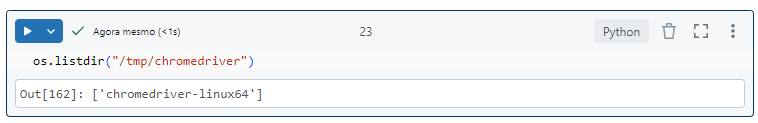

#2. Ingestão e tratamento dos dados da requisição

> A proposta é que a solução tenha futuramente um *front-end* onde o cliente poderá fazer sua solicitação e selecionar suas opções dentre uma lista de pontos turísticos oferecidos na cidade de destino. Em um primeiro momento, serão utilizados dados de exemplo com a lista de estádios selecionados pelo turista do atual estudo de caso. Os dados serão ingeridos através do GitHub.

> Será necessário também que o cliente indique o local onde ficará hospedado, de forma que seja possível se criar um HUB de onde os turismos diários se iniciarão.

In [ ]:
### UBICACION
UBIC = {'geometry':shp.geometry.Point(-58.40025842189126, -34.58895436234146),
        'url':'-34.58895436234146,-58.40025842189126', 'Estádio':'home'} ### LOCAL DE HOSPEDAGEM

### GEOJSON BUENOS AIRES
ba = gpd.read_file("https://github.com/fersondahl/Sprint_eng_dados/raw/main/Buenos%20aires.GEOJSON") ### MAPA DA CIDADE

### PONTOS TURÍSTICOS
canchas = pd.read_excel("https://github.com/fersondahl/Sprint_eng_dados/raw/main/Pontos%20tur%C3%ADsticos.xlsx") ### BASE COM PONTOS TURÍSTICOS (ESTÁDIOS)
canchas['geometry'] = list(map(lambda lng, lat: shp.geometry.Point(lng, lat), canchas['Longitude'], canchas['Latitude']))
canchas['url'] = list(map(lambda lng, lat: str(lat)+","+str(lng), canchas['Longitude'], canchas['Latitude']))
canchas = gpd.GeoDataFrame(canchas)

##2.1 Problema inicial do Estudo de caso

> Para facilitar a visualização do problema inicial é gerado o mapa a seguir. Em vermelho está o HUB de partida do cliente, e em azul todos os pontos turísticos que ele desejará passar durante sua estadia na cidade;

> O modelo deverá ser capaz de agrupar os pontos turísticos em diferentes dias e ordem que minimize o tempo total de trajeto durante a viagem.

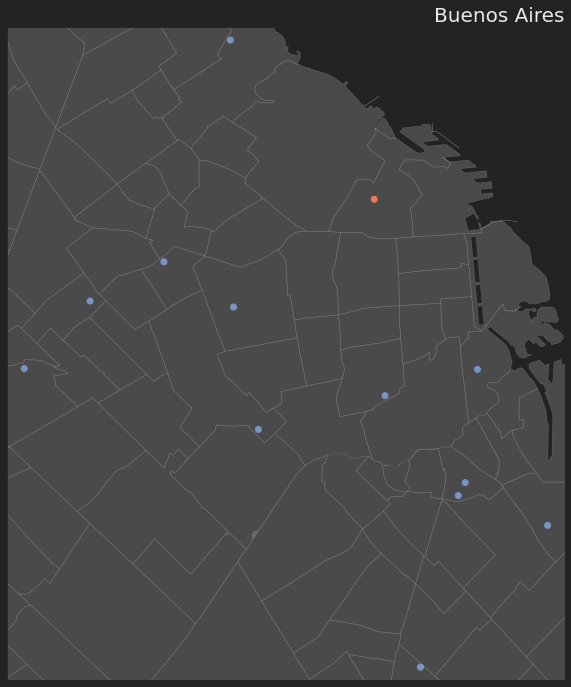

In [ ]:
canchas_ub = pd.concat([canchas,
    gpd.GeoDataFrame(UBIC, index=[0])], axis=0)

obj_limits = shp.ops.unary_union(canchas_ub['geometry']).bounds ### DEFINIÇÃO DA ÁREA DE INTERESSE

with sns.axes_style({'axes.facecolor': '#232323', 'figure.facecolor': '#232323',
    'axes.edgecolor': '#232323', 'xtick.bottom': False, 'xtick.top': False,
    'ytick.left': False, 'ytick.right': False}):

    fig, ax = plt.subplots()
    canchas_ub.plot(ax=ax, color=np.where(canchas_ub['Clube'].isna(), '#F95738', '#5C80BC')) ### PLOT DOS LOCAIS

    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ba.plot(ax=ax, alpha=.2, color='#EAEAEA', edgecolor='#EAEAEA', linewidth=.5) ### PLOT DA CAMADA DE BUENOS AIRES

    ax.set_title('Buenos Aires', loc='right', fontproperties='bahnschrift', size=20, color='#EAEAEA')

    ### ZOOM PARA ÁREA DE INTERESSE
    ax.set_ylim(top=obj_limits[-1]*.9999, bottom=obj_limits[1]*1.0001)
    ax.set_xlim(right=obj_limits[-2]*.9999, left=obj_limits[0]*1.0001)

    fig.set_figheight(12)
    fig.set_figwidth(12)


#3. Ingestão dos dados de rota

> Para que seja possível implementar o modelo de otimização de rotas é necessário que se tenha uma base com todos os tempos de percursso em cada um dos nós do problema (HUB e pontos turísticos);

> Para esse caso, foi escolhida a opção de se usar o SELENIUM para consultar todos esses tempos de percurso através do Google Maps.

In [ ]:
prd_cnc = pd.DataFrame(list(itertools.product(*[canchas_ub['Estádio'], canchas_ub['Estádio']])), columns=['origin', 'destin']) ## TABELA COM COMBINAÇÃO DE TODAS AS ORIGENS E DESTINOS

prd_cnc = prd_cnc[prd_cnc['origin'] != prd_cnc['destin']].reset_index(drop=True)

for col in ['origin', 'destin']:
    prd_cnc = pd.merge(left=prd_cnc, right=canchas_ub[['Estádio', 'url']].rename(columns={'Estádio':col, 'url':f'url_{col}'}), on=col, how='left')

prd_cnc

,origin,destin,url_origin,url_destin
0,Estádio Alberto José Armando,Estádio Pedro Bidegain,"-34.6356109,-58.3647562999999","-34.6520743,-58.4401201999999"
1,Estádio Alberto José Armando,Estádio Monumental Antonio Vespucio Liberti,"-34.6356109,-58.3647562999999","-34.5452995,-58.4497634"
2,Estádio Alberto José Armando,Estádio Presidente Perón,"-34.6356109,-58.3647562999999","-34.6666461,-58.368945"
3,Estádio Alberto José Armando,Estádio Libertadores de América,"-34.6356109,-58.3647562999999","-34.6702197,-58.3713407"
4,Estádio Alberto José Armando,Estádio Tomás Adolfo Ducá,"-34.6356109,-58.3647562999999","-34.6428277,-58.3965507"
...,...,...,...,...
151,home,Estádio Julio Humberto Grondona,"-34.58895436234146,-58.40025842189126","-34.6783811,-58.3406089"
152,home,Estádio Cidade de Lanús,"-34.58895436234146,-58.40025842189126","-34.7172622,-58.3843612"
153,home,Estádio José Amalfitani,"-34.58895436234146,-58.40025842189126","-34.635406,-58.5206968"
154,home,Estádio Arquiteto Ricardo Etcheverri,"-34.58895436234146,-58.40025842189126","-34.6185047584204,-58.448682102283"


In [ ]:
def init_chrome_browser(download_path, chrome_driver_path,  url):     ### CONFIGURAÇÃO DO CHROME DRIVER
    options = webdriver.ChromeOptions()
    options.add_argument('--no-sandbox')
    options.add_argument('--headless')
    options.add_argument('--start-maximized')
    browser = webdriver.Chrome(service=Service(chrome_driver_path), options=options)
    browser.get(url)
    return browser

driver = init_chrome_browser(  ### INICIALIZAÇÃO DO BROWSER
    download_path="/tmp/downloads",
    chrome_driver_path="/tmp/chromedriver/chromedriver-linux64/chromedriver",
    url= "https://www.google.com/maps?authuser=0"
)

WebDriverWait(driver, 5).until(
    EC.presence_of_element_located((By.ID, 'hArJGc'))
)

rota_btn = driver.find_element(By.ID, 'hArJGc')

rota_btn.click()

WebDriverWait(driver, 5).until(
    EC.presence_of_element_located((By.CLASS_NAME, 'tactile-searchbox-input'))
)

def get_travel_time(orig_url:str, dest_url:str):
    ### SELEÇÃO E INPUT DA ORIGEM DO PERCURSO
    orign = driver.find_elements(By.CLASS_NAME, 'tactile-searchbox-input')[0]
    orign.clear()
    orign.send_keys(orig_url)

    ### SELEÇÃO E INPUT DO DESTINO DO PERCURSO
    dest = driver.find_elements(By.CLASS_NAME, 'tactile-searchbox-input')[1]
    dest.clear()
    dest.send_keys(dest_url + Keys.ENTER)


    WebDriverWait(driver, 5).until(
        EC.presence_of_element_located((By.CLASS_NAME, 'Fl2iee'))
    )

    ### SELEÇÃO DOS TEMPOS DE DESLOCAMENTO
    tempos = driver.find_elements(By.CLASS_NAME, 'FkdJRd')[0].text

    return tempos.split('\n')[1:]


result = {}

for ind, cancha in prd_cnc.iterrows():
    result.update({ind:get_travel_time(cancha['url_origin'], cancha['url_destin'])})


> Por fim, é gerada a matriz de distâncias entre todos os nós do problema.

In [ ]:
travel_times = pd.DataFrame.from_dict(result, orient='index', columns=['carro', 'transporte publico', 'andando', 'bicicleta']).fillna("1 min")

for col in travel_times.columns:
    travel_times[col] = travel_times[col].apply(lambda linha: int(linha.split(" hr")[0])*60 + (int(linha.split(" hr")[-1].replace(" min", "")) if linha.split(" hr")[-1] != "" else 0) if "hr" in linha else int(linha.split(" min")[0])

    )

travel = pd.merge(left=prd_cnc[['origin', 'destin']], right=travel_times, left_index=True, right_index=True)

travel

,origin,destin,carro,transporte publico,andando,bicicleta
0,Estádio Alberto José Armando,Estádio Pedro Bidegain,22,50,108,32
1,Estádio Alberto José Armando,Estádio Monumental Antonio Vespucio Liberti,29,64,212,54
2,Estádio Alberto José Armando,Estádio Presidente Perón,15,29,62,18
3,Estádio Alberto José Armando,Estádio Libertadores de América,14,35,68,19
4,Estádio Alberto José Armando,Estádio Tomás Adolfo Ducá,11,22,46,13
...,...,...,...,...,...,...
151,home,Estádio Julio Humberto Grondona,37,56,185,53
152,home,Estádio Cidade de Lanús,51,52,216,63
153,home,Estádio José Amalfitani,39,46,180,55
154,home,Estádio Arquiteto Ricardo Etcheverri,32,38,87,27


#4. Modelo de Otimização de roteiro

> Para a otimização das rotas entre os pontos turísticos foi utilizada a modelagem a partir de programação linear inteira, com base no Problema do caixeiro viajante. Foi utilizada a formulação DFJ para inibir o sub-roteamento e adotou-se o método de *lazy constraints* para a não explosão exponencial do problema.
A cada iteração, são verificadas as sub-rotas contidas na solução e são adicionadas restrições para impedi-las. As iterações findam quando a solução  encontra apenas um ciclo ligando todos os nós.

### Modelagem

*max* $\sum_{j=1}^{n}$ $\sum_{i=1}^{n}$ $x_{ij}$ * $d_{ij}$

*St.*

$\sum_{i=1}^{n}$ $x_{ij}$ = 1, ∀ j | j ≠ i

$\sum_{j=1}^{n}$ $x_{ij}$ = 1, ∀ i | j ≠ i

0 ≤ $x_{ij}$ ≤ 1, $x_{ij}$ ∈ ℤ

Sendo:

$x_{ij}$: Variável binária que assumirá 1 se o trajeto entre os pontos turísticos ou *hub* (nós) *i* e *j* for percorrido, e 0 caso contrário.

$d_{ij}$: A distância entre os nós *i* e *j*.

In [ ]:

t_time = travel.copy()
t_time[['origin', 'destin']] = t_time[['origin', 'destin']].replace('home', 'home_0')

DAYS = 3 ### DIAS DE TURISMO NA VIAGEM

for i in range(DAYS-1):
    adc_home = t_time[(t_time['origin'] == 'home_0') ^ (t_time['destin'] == 'home_0')].replace("home_0", f"home_{i+1}")
    t_time = pd.concat([t_time, adc_home])

reindexer = list(itertools.product(*[t_time['origin'].drop_duplicates(), t_time['origin'].drop_duplicates()]))

distance_matrix = t_time.set_index(['origin', 'destin']).reindex(reindexer).fillna(10000000).to_dict()['carro']

subciclo = []

h_subciclo = True
locais = t_time['origin'].drop_duplicates().to_list()

while h_subciclo:

    model = pyo.ConcreteModel() ### INSTANCIAÇÃO DO MODELO

    p_size = len(t_time['origin'].drop_duplicates())

    model.aresta = pyo.Var(list(distance_matrix.keys()), bounds=(0, 1), within=Integers)
    aresta = model.aresta

    model.C1 = pyo.ConstraintList()
    for i in locais:
        model.C1.add(expr= sum(aresta[i, j] for j in locais) == 1)  ### OBRIGAÇÃO DE SAIR DE TODOS OS NÓS DO PROBLEMA
        model.C1.add(expr= sum(aresta[j, i] for j in locais) == 1) ### OBRIGAÇÃO DE CHEGAR EM TODOS OS NÓS DO PROBLEMA

    model.C2 = pyo.ConstraintList()
    for i in locais:
        model.C2.add(expr= aresta[i, i] ==0)    ### IMPEDIR NÓ DE SAIR E CHEGAR EM SI PRÓPRIO

    model.restS = pyo.ConstraintList()
    for s in subciclo:
        model.restS.add(expr =sum(aresta[i, j] for i in s for j in s) - len(s) <=  -1) ### COIBIR SUB-CICLOS GERADOS

    model.obj = pyo.Objective(expr= sum(aresta[i, j]*distance_matrix[(i, j)] for i in locais for j in locais),
                            sense=pyo.minimize) # Restrição [6]

    opt = SolverFactory('glpk', executable="/usr/bin/glpsol") ### SOLVER
    opt.solve(model)

    result = []
    resultado = []

    vet_mult = list(range(p_size))

    for i in locais: ### COLETA DA SOLUÇÃO DO MODELO
        resultado.append(int(sum(pyo.value(aresta[(i,j)])*vet_mult[locais.index(j)] for j in locais)))

    roteiro = pd.DataFrame(locais, columns=['origem'])

    roteiro['id_destino'] = resultado
    roteiro['destino'] = roteiro['id_destino'].apply(lambda linha: locais[linha])

    partida = 0
    order, order_aux = [], []
    subciclos_locais = []

    h_subciclo = False
    while len(order) != len(roteiro): ### VERIFICAÇÃO SE HÁ A PRESENÇA DE SUB-CICLOS NA SOLUÇÃO
        destino = roteiro.loc[partida]['id_destino']
        if destino in order:
            h_subciclo = True
            subciclos_locais.append(order_aux)
            partida = pd.Series(filter(lambda elem: elem not in order, roteiro.index)).min()
            order_aux = []
        else:
            order.append(destino)
            order_aux.append(locais[destino])
            partida = roteiro.loc[partida]['id_destino']

    subciclo += subciclos_locais

for col in ['origem', 'destino']:
    roteiro = pd.merge(left=roteiro, right=canchas_ub[['Estádio', 'geometry']].rename(
        columns={'Estádio':col, 'geometry':f'geo_{col}'}),
             on=col, how='left')

### ROTEIRO FINAL
roteiro = roteiro.fillna(UBIC['geometry'])
roteiro['trajeto'] = roteiro[['geo_origem', 'geo_destino']].agg(shp.geometry.LineString, axis=1)
roteiro = roteiro.set_index('id_destino').loc[order].reset_index()
roteiro['trajeto_center'] = roteiro['trajeto'].apply(lambda linha: linha.centroid)
roteiro['travel_time'] = list(map(lambda orig, dest: distance_matrix[(orig, dest)],
                                  roteiro['origem'], roteiro['destino']))

roteiro

,id_destino,origem,destino,geo_origem,geo_destino,trajeto,trajeto_center,travel_time
0,7,Estádio Alberto José Armando,Estádio Julio Humberto Grondona,POINT (-58.36476 -34.63561),POINT (-58.34061 -34.67838),"LINESTRING (-58.3647562999999 -34.6356109, -58...",POINT (-58.352682599999945 -34.65699600000001),14.0
1,8,Estádio Julio Humberto Grondona,Estádio Cidade de Lanús,POINT (-58.34061 -34.67838),POINT (-58.38436 -34.71726),"LINESTRING (-58.3406089 -34.6783811, -58.38436...",POINT (-58.362485050000004 -34.69782165),19.0
2,4,Estádio Cidade de Lanús,Estádio Libertadores de América,POINT (-58.38436 -34.71726),POINT (-58.37134 -34.67022),"LINESTRING (-58.3843612 -34.7172622, -58.37134...",POINT (-58.377850949999996 -34.69374095),19.0
3,3,Estádio Libertadores de América,Estádio Presidente Perón,POINT (-58.37134 -34.67022),POINT (-58.36894 -34.66665),"LINESTRING (-58.3713407 -34.6702197, -58.36894...",POINT (-58.370142849999986 -34.6684329),3.0
4,14,Estádio Presidente Perón,home_2,POINT (-58.36894 -34.66665),POINT (-58.40026 -34.58895),"LINESTRING (-58.368945 -34.6666461, -58.400258...",POINT (-58.38460171094563 -34.62780023117073),28.0
5,2,home_2,Estádio Monumental Antonio Vespucio Liberti,POINT (-58.40026 -34.58895),POINT (-58.44976 -34.5453),LINESTRING (-58.40025842189126 -34.58895436234...,POINT (-58.42501091094563 -34.56712693117073),19.0
6,12,Estádio Monumental Antonio Vespucio Liberti,home_0,POINT (-58.44976 -34.5453),POINT (-58.40026 -34.58895),"LINESTRING (-58.4497634 -34.5452995, -58.40025...",POINT (-58.42501091094563 -34.56712693117073),20.0
7,5,home_0,Estádio Tomás Adolfo Ducá,POINT (-58.40026 -34.58895),POINT (-58.39655 -34.64283),LINESTRING (-58.40025842189126 -34.58895436234...,POINT (-58.398404560945636 -34.61589103117073),30.0
8,1,Estádio Tomás Adolfo Ducá,Estádio Pedro Bidegain,POINT (-58.39655 -34.64283),POINT (-58.44012 -34.65207),"LINESTRING (-58.3965507 -34.6428277, -58.44012...",POINT (-58.41833544999995 -34.647451000000004),11.0
9,9,Estádio Pedro Bidegain,Estádio José Amalfitani,POINT (-58.44012 -34.65207),POINT (-58.5207 -34.63541),"LINESTRING (-58.4401201999999 -34.6520743, -58...",POINT (-58.48040849999996 -34.64374015),17.0


##4.1 Solução do modelo de otimização

> O resultado entregue ao cliente é a distribuição entre dias e percursos a serem percorridos para um turismo eficiente na cidade.

<command-1909824633946072>:7: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  cancha_image = plt.imread("https://github.com/fersondahl/Sprint_eng_dados/raw/main/assets/estadio.png")
<command-1909824633946072>:8: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  ap_image = plt.imread("https://github.com/fersondahl/Sprint_eng_dados/raw/main/assets/apartamento.png")


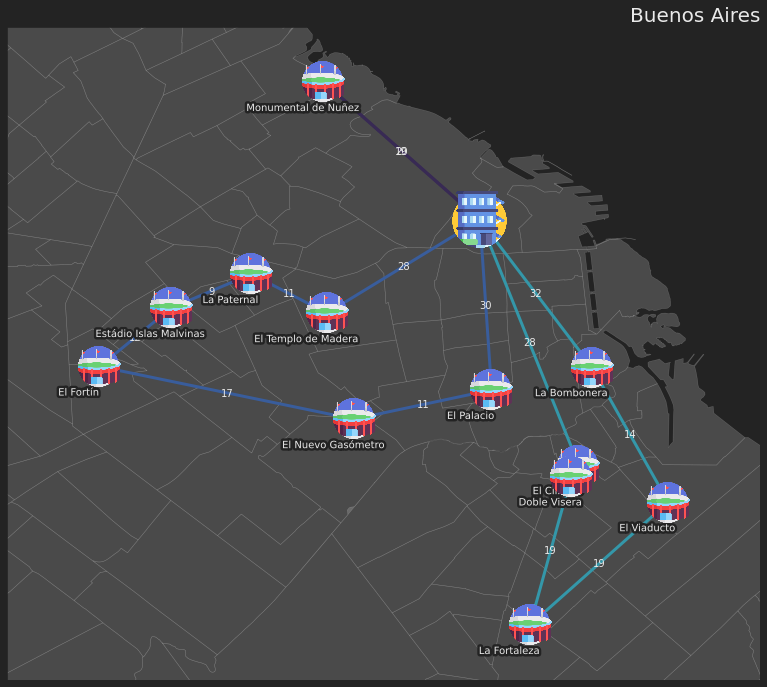

In [ ]:
color_trajeto = sns.color_palette('mako', n_colors=DAYS+1).as_hex()

roteiro['color'] = roteiro['destino'].apply(lambda linha: color_trajeto[int(linha.split("_")[-1])] if "home" in linha else pd.NA).fillna(method='bfill')

roteiro['color'] = roteiro['color'].fillna(roteiro['color'].iloc[0])

cancha_image = plt.imread("https://github.com/fersondahl/Sprint_eng_dados/raw/main/assets/estadio.png")
ap_image = plt.imread("https://github.com/fersondahl/Sprint_eng_dados/raw/main/assets/apartamento.png")

with sns.axes_style({'axes.facecolor': '#232323', 'figure.facecolor': '#232323',
    'axes.edgecolor': '#232323', 'xtick.bottom': False, 'xtick.top': False,
    'ytick.left': False, 'ytick.right': False}):

    fig, ax = plt.subplots()

    ba.plot(ax=ax, alpha=.2, color='#EAEAEA', edgecolor='#EAEAEA', linewidth=.5)
    canchas_ub.plot(ax=ax)

    ax.set_xlim(left=obj_limits[0]*1.0005, right=obj_limits[2]*0.9995)
    ax.set_ylim(bottom=obj_limits[1]*1.0005, top=obj_limits[-1]*0.9995)

    ax.set_xticklabels([])
    ax.set_yticklabels([])

    roteiro.set_geometry('trajeto').plot(ax=ax, color=roteiro['color'], linewidth=3)

    for ind, rota in roteiro.iterrows():

            ax.annotate(text=int(rota['travel_time']), xy=rota['trajeto_center'].coords[0],
                        size=10, ha='center', va='center', fontproperties='bahnschrift', color="#EAEAEA")

    for ind, cancha in canchas.iterrows():

        ax.annotate(text=" ".join(cancha['Nome Popular'].split(" ")), xy=cancha['geometry'].coords[0],
                    xytext=cancha['geometry'].coords[0]+(np.mean(cancha['geometry'].coords[0])/7000),
                    size=10, ha='center', va='top', fontproperties='bahnschrift', color='#EAEAEA',
                    path_effects=[pe.withStroke(foreground='#232323', linewidth=5 )])

        im = OffsetImage(cancha_image, zoom=6/ax.figure.dpi)
        im.image.axes = ax

        xi = cancha['geometry'].coords[0][0]
        yi = cancha['geometry'].coords[0][1]
        ab = AnnotationBbox(im, (xi,yi), frameon=False, pad=0.0)
        ax.add_artist(ab)

    im = OffsetImage(cancha_image, zoom=6/ax.figure.dpi)
    im.image.axes = ax

    xi = cancha['geometry'].coords[0][0]
    yi = cancha['geometry'].coords[0][1]
    ab = AnnotationBbox(im, (xi,yi), frameon=False, pad=0.0,)
    ax.add_artist(ab)

    im_ap = OffsetImage(ap_image, zoom=8/ax.figure.dpi)
    im_ap.image.axes = ax
    ax.add_artist(AnnotationBbox(im_ap, UBIC['geometry'].coords[0], frameon=False, pad=0.0,))

    ax.set_title('Buenos Aires', loc='right', fontproperties='bahnschrift', size=20, color='#EAEAEA')

    fig.set_figheight(12)
    fig.set_figwidth(20)



#5. Saída dos dados para o DataLake

> Os dados gerados pela requisição e modelo serão salvos no catálogo do *databricks*.

> O objetivo de se entregar um roteiro eficiente para o cliente já foi concluído. Entretanto, muito se pode extrair através dos dados gerados pelo modelo;

> A seleção de pontos turísticos pelos clientes pode trazer, por exemplo, para as prefeituras pontos turísticos preferidos e preteridos. Essa informação pode:
>  1. Realocar investimentos para áreas menos visitadas da cidade para que se tornem mais atrativas;
>  2. Encontrar sazonalidades nas buscas por esses pontos turísticos;
>  3. Auxiliar as estratégias para os planos de mobilidade urbana de forma a atender os fluxos mais intensos de demanda turística.

> Avaliando os perfil dos clientes e perfil de seleções também podem ser gerados modelos de associação que definam padrões de escolha pelos clientes, em que possam ser criados e oferecidos pacotes de experiências conjuntas que atraiam ainda mais clientes.

> É gerada também uma base com o resumo da requisição do cliente, quantidade de dias de turismo, de pontos turísticos e é gerado um indicador de eficiência (route_eff) que mede o tempo necessário médio para se chegar em cada experiência. Esse indicador pode gerar *insights* relacionados a:
  1. Um indicador muito alto pode demonstrar comparativamente que a mobilidade para "aproveitar" uma cidade pode estar aquém em relações a outras;
  2. Pode se fazer uma associação entre a seleção de determinados pontos turísticos e o aumento do indicador, o que demonstra que ele está de alguma maneira isolado das demais preferências, em que se pode observar oportunidades para compor turisticamente aquela região.


In [ ]:

#%%% REQUESTS DETAIL TABLE
req_client = round(datetime.now().timestamp()) ### ATRAVÉS DO CADASTRO NA FERRAMENTA E FRONT-END O CÓDIGO DO CLIENTE VIRÁ ATRAVÉS DA REQUISIÇÃO

sdf_cancha = spark.createDataFrame(canchas.drop('geometry', axis=1)) ### TRANSFORMA O DATAFRAME EM UM DATAFRAME SPARK
sdf_cancha = sdf_cancha.withColumnRenamed("Nome Popular", "Nome_Popular")

sdf_cancha = sdf_cancha.withColumn("client_request",  lit(client))

sdf_cancha.show()
sdf_cancha.write.saveAsTable("default.attractns")

#%%% CLIENT REQUESTS TABLE
roteiro_df = roteiro.copy()
roteiro_df['client_request'] = client

roteiro_df = roteiro_df.groupby('client_request').agg({
    'origem':len, 'color': lambda col: len(col.unique()), 'travel_time':sum
}).rename(columns={'origem':'n_attractions', 'color': 'trip_days'}).reset_index()


roteiro_df['route_eff'] = roteiro_df['travel_time']/roteiro_df['n_attractions']

roteiro_df['client'] = 'Fer'

sdf_roteiro = spark.createDataFrame(roteiro_df)

sdf_roteiro.show()
sdf_roteiro.write.saveAsTable("default.client_request")


+--------------------+--------------------+------------------+-----------------+-----------------+--------------------+--------------+
|             Estádio|        Nome_Popular|             Clube|         Latitude|        Longitude|                 url|client_request|
+--------------------+--------------------+------------------+-----------------+-----------------+--------------------+--------------+
| Estádio Alberto ...|        La Bombonera|      Boca Juniors|      -34.6356109|-58.3647562999999|-34.6356109,-58.3...|    1720812097|
|Estádio Pedro Bid...|  El Nuevo Gasómetro|       San Lorenzo|      -34.6520743|-58.4401201999999|-34.6520743,-58.4...|    1720812097|
| Estádio Monument...| Monumental de Nuñez|       River Plate|      -34.5452995|      -58.4497634|-34.5452995,-58.4...|    1720812097|
|Estádio President...|         El Cilindro|       Racing Club|      -34.6666461|       -58.368945|-34.6666461,-58.3...|    1720812097|
|Estádio Libertado...|        Doble Visera|     Indepen

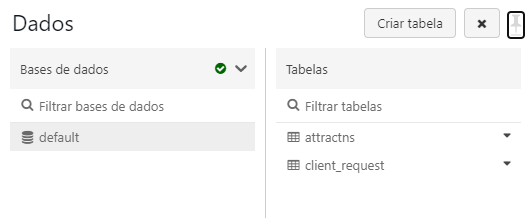

## 5.1 Esquema do *DataLake*

> O esquema do *datalake* está dividido em duas diferentes fontes: o cadastro na ferramenta que gera a base de clientes e a própria solução na nuvem.

> No centro da estrela estará a tabela fato *client_request* com o resumo de cada requisição feita. Ela será categorizada pelas bases *attractns*, também fato, com informações de todos os pontos turísticos selecionados em cada uma das requisições e pela tabela dimensão de clientes.

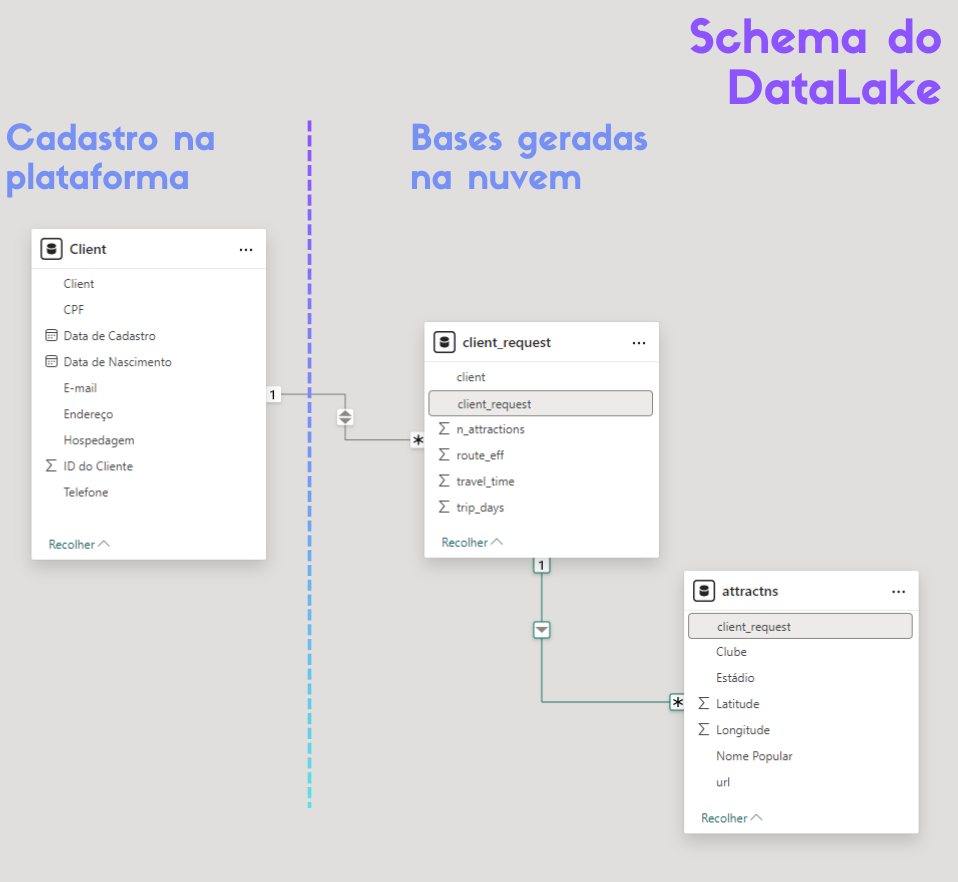

#6. Próximos passos


> Além do desenvolvimento do *front-end* e sua conexão com o registro cadastral dos clientes, será necessário utilizar de ferramentas mais avançadas que versão gratuita do *databricks* para conectar as requisições feitas pelos clientes com a modelagem, a respota da solução e a ingestão no *DataLake*.